# Using Gluon with Xfer

This notebook demonstrates how to use neural networks defined and trained with Gluon as source models for Transfer Learning with Xfer.

> TLDR; Gluon models can be used with Xfer provided they use [HybridBlocks](https://gluon.mxnet.io/chapter07_distributed-learning/hybridize.html) so that the symbol can be extracted.

In [1]:
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
mx.random.seed(1)

import time
from sklearn.metrics import classification_report
from scipy import io as scipyio
import urllib.request
import zipfile
import os
import logging

import xfer

## Train CNN with gluon

Using code taken from [The Straight Dope](https://gluon.mxnet.io/chapter04_convolutional-neural-networks/cnn-gluon.html)

In [2]:
ctx = mx.cpu()

In [3]:
batch_size = 64
num_inputs = 784
num_outputs = 10
def transform(data, label):
    return nd.transpose(data.astype(np.float32), (2,0,1))/255, label.astype(np.float32)
train_data = gluon.data.DataLoader(gluon.data.vision.MNIST(train=True, transform=transform),
                                      batch_size, shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.vision.MNIST(train=False, transform=transform),
                                     batch_size, shuffle=False)

In [4]:
num_fc = 512
net = gluon.nn.HybridSequential()
with net.name_scope():
    net.add(gluon.nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Conv2D(channels=50, kernel_size=5, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    # The Flatten layer collapses all axis, except the first one, into one axis.
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(num_fc, activation="relu"))
    net.add(gluon.nn.Dense(num_outputs))

In [5]:
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

In [6]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [7]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': .1})

In [8]:
net.hybridize()

In [9]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [10]:
epochs = 1
smoothing_constant = .01

for e in range(epochs):
    start_time_train = time.time()
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(data.shape[0])

        ##########################
        #  Keep a moving average of the losses
        ##########################
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (curr_loss if ((i == 0) and (e == 0))
                       else (1 - smoothing_constant) * moving_loss + smoothing_constant * curr_loss)
    end_time_train = time.time()

    start_time_eval = time.time()
    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    end_time_eval = time.time()
    
    epoch_time = end_time_train - start_time_train
    eval_time = end_time_eval - start_time_eval
    print("Epoch {}.\nLoss: {}, Train_acc {}, Test_acc {}, Epoch_time {}, Eval_time {}".format(e, moving_loss, train_accuracy, test_accuracy, epoch_time, eval_time))
    

Epoch 0.
Loss: 0.07521554497942881, Train_acc 0.9786333333333334, Test_acc 0.9793, Epoch_time 60.99967002868652, Eval_time 30.03406596183777


## Load emnist letters dataset

Dataset info [here](https://www.nist.gov/itl/iad/image-group/emnist-dataset)

In [11]:
def get_emnist_dataset(dir_name='emnist-matlab'):
    if dir_name in os.listdir():
        logging.info('Dataset already exists.')
        return
    url = 'http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip'
    filename = 'emnist-matlab.zip'
    logging.info('Downloading dataset...')
    urllib.request.urlretrieve(url, filename)
    logging.info('Extracting dataset...')
    with zipfile.ZipFile(filename, 'r') as zip_file:
        zip_file.extractall(dir_name)
    logging.info('Deleting temp files...')
    os.remove('filename')
    logging.info('Done')

In [12]:
DIRNAME = 'emnist-matlab'

In [13]:
get_emnist_dataset(DIRNAME)

In [14]:
emnist = scipyio.loadmat(os.path.join(DIRNAME,'matlab/emnist-letters.mat'))

In [15]:
train_data = emnist['dataset'][0][0][0][0][0][0]
train_label = emnist['dataset'][0][0][0][0][0][1]

test_data = emnist['dataset'][0][0][1][0][0][0]
test_label = emnist['dataset'][0][0][1][0][0][1]

In [16]:
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(124800, 784)
(124800, 1)
(20800, 784)
(20800, 1)


In [17]:
# reshape using matlab order
train_data = train_data.reshape(train_data.shape[0], 1, 28, 28, order="A")
test_data = test_data.reshape(test_data.shape[0], 1, 28, 28, order="A")

In [18]:
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(124800, 1, 28, 28)
(124800, 1)
(20800, 1, 28, 28)
(20800, 1)


In [19]:
# reshape labels
train_label = np.array([label[0] for label in train_label])
test_label = np.array([label[0] for label in test_label])

In [20]:
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(124800, 1, 28, 28)
(124800,)
(20800, 1, 28, 28)
(20800,)


In [21]:
import matplotlib.pyplot as plt

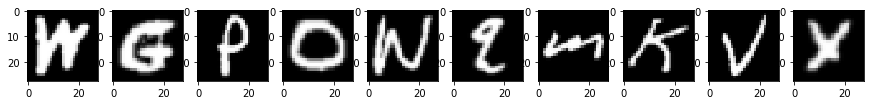

In [22]:
fig, ax = plt.subplots(1, 10, figsize=(15,6))
for n in range(10):
    ax[n].imshow(train_data[n][0], cmap='gray')

In [23]:
train_iter = mx.io.NDArrayIter(train_data, train_label, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(test_data, test_label, batch_size)

## Convert Gluon model `net` to Module

*Adapted from snippet found [here](https://github.com/apache/incubator-mxnet/issues/9374)*

From the Gluon model, the symbol and parameters are extracted and used to define an `Module` object.

In [24]:
def block2symbol(block):
    data = mx.sym.Variable('data')
    sym = block(data)
    args = {}
    auxs = {}
    for k, v in block.collect_params().items():
        args[k] = mx.nd.array(v.data().asnumpy())
        auxs[k] = mx.nd.array(v.data().asnumpy())
    return sym, args, auxs

In [25]:
def symbol2mod(sym, args, auxs, data_iter):
    mx_sym = mx.sym.SoftmaxOutput(data=sym, name='softmax')
    model = mx.mod.Module(symbol=mx_sym, context=mx.cpu(), 
                          label_names=['softmax_label'])
    model.bind( data_shapes = data_iter.provide_data, 
                label_shapes = data_iter.provide_label )
    model.set_params(args, auxs)  
    return model

In [26]:
sym_params = block2symbol(net)

In [27]:
net_mod = symbol2mod(*sym_params, train_iter)

### Alternative Method

Serialise Gluon model to file using `.export()`.

Load the serialised model as an MXNet Module with `Module.load()` so that xfer can be used.

In [28]:
# model_name = 'gluon-model'
# net.export(model_name)

# mod = mx.mod.Module.load(model_name, 0, label_names=[])
# os.remove(model_name+'-symbol.json')
# os.remove(model_name+'-0000.params')

### Inspect Module 

In [29]:
mh = xfer.model_handler.ModelHandler(net_mod)

In [30]:
mh.layer_names

['hybridsequential0_conv0_fwd',
 'hybridsequential0_conv0_relu_fwd',
 'hybridsequential0_pool0_fwd',
 'hybridsequential0_conv1_fwd',
 'hybridsequential0_conv1_relu_fwd',
 'hybridsequential0_pool1_fwd',
 'hybridsequential0_flatten0_reshape0',
 'hybridsequential0_dense0_fwd',
 'hybridsequential0_dense0_relu_fwd',
 'hybridsequential0_dense1_fwd',
 'softmax']

## Neural Network Repurposer

In [31]:
repFT = xfer.NeuralNetworkFineTuneRepurposer(source_model=net_mod,
                                             transfer_layer_name='hybridsequential0_dense0_relu_fwd',
                                             target_class_count=26, num_epochs=2)

In [32]:
repFT.repurpose(train_iter)

/anaconda/envs/xfer-env/lib/python3.6/site-packages/mxnet/module/base_module.py:488: UserWarning: Parameters already initialized and force_init=False. init_params call ignored.
  allow_missing=allow_missing, force_init=force_init)


In [33]:
predictionsFT = repFT.predict_label(val_iter)

In [34]:
print(classification_report(test_label, predictionsFT,
      digits=3))

             precision    recall  f1-score   support

          1      0.248     0.045     0.076       800
          2      0.506     0.406     0.451       800
          3      0.444     0.403     0.422       800
          4      0.928     0.242     0.385       800
          5      0.149     0.956     0.258       800
          6      0.667     0.646     0.657       800
          7      0.327     0.120     0.176       800
          8      0.339     0.485     0.399       800
          9      0.000     0.000     0.000       800
         10      0.434     0.849     0.574       800
         11      0.666     0.500     0.571       800
         12      0.451     0.635     0.528       800
         13      0.769     0.839     0.803       800
         14      0.637     0.541     0.585       800
         15      0.750     0.004     0.007       800
         16      0.782     0.520     0.625       800
         17      0.857     0.015     0.029       800
         18      0.819     0.221     0.348   

/anaconda/envs/xfer-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In this case, finetuning doesn't produce strong results.

## Meta-model Repurposer

In [35]:
repLR = xfer.LrRepurposer(source_model=net_mod, feature_layer_names=['hybridsequential0_dense0_fwd'])

In [36]:
repLR.repurpose(train_iter)

/anaconda/envs/xfer-env/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [37]:
predictionsLR = repLR.predict_label(val_iter)

In [38]:
print(classification_report(test_label, predictionsLR,
      digits=3))

             precision    recall  f1-score   support

          1      0.880     0.895     0.887       800
          2      0.932     0.932     0.932       800
          3      0.954     0.949     0.951       800
          4      0.930     0.911     0.920       800
          5      0.940     0.948     0.944       800
          6      0.953     0.939     0.946       800
          7      0.811     0.761     0.785       800
          8      0.903     0.922     0.913       800
          9      0.727     0.736     0.732       800
         10      0.923     0.919     0.921       800
         11      0.948     0.950     0.949       800
         12      0.734     0.760     0.747       800
         13      0.976     0.975     0.976       800
         14      0.928     0.922     0.925       800
         15      0.925     0.963     0.944       800
         16      0.946     0.973     0.959       800
         17      0.808     0.789     0.798       800
         18      0.939     0.905     0.922   

LR repurposer achieves much better performance.